# Getting started with ITVG

Ion Trap Voltage Generation (ITVG) is a Python module written to generate voltage sets to apply to ion trap electrodes to produce electric potentials satisfying a variety of user-specified constraints, based on COMSOL simulations giving the effect of unit voltages on each trap electrode.

The approach we take is as follows:
1. Import grid files from COMSOL which represent the unit potentials in space.
2. Group electrodes that will be tied together and specify the RF electrodes and paramters.
3. Specify points of interest. 
    * Express this potential as an order $N$ polynomial in $(x,y,z)$ by performing a least-squares fit to the points
    * Obtain this expression for a unit voltage application to each electrode set.
3. Specify constraints which describe the desired potential.
    * Constraints are specified as coefficients of the polynomial, e.g. the `xx` or `xyzz` coefficients.
    * Working in coefficients, we now have a linear problem to solve.
4. Solve the least-squares problem of satisfying the coefficient constraints.
    * Solve $C \mathbf v = \mathbf y$ where C is a matrix of observed coefficients for unit applied voltages to each electrode set.
    * This is often overdetermined, so we find the least-squares solution for $\mathbf v$.
    * In the future we would like to incorporate a more sophisticated approach permitting a general cost function.

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import scipy

Import the module! If Python reports it doesn't exist, make sure you've installed it in the conda environment that the IPython kernel comes from. We load autoreload so we can edit the library code while we play with it in Jupyter, if we find we need to.

In [2]:
import VoltageGeneration

%load_ext autoreload
%autoreload 2

## The `VoltageGeneration` object

The first step is to initialize the `VoltageGeneration` object with the parameters of our trap, among other things. For a full description of all the allowed arguments (of which these here form a subset), see the code. This object will hold all the information from the grid files, so it will take a while to run if your grid files are large (for 6 GB, we need ~400 s). Take the time to skim the documentation!

Of note here is `f_cons`, which supplies default constraints to use in generating all voltage sets (unless overridden by a new value). Typically we want to force the linear fields at points of interest to 0 (to be at a potential minimum), so we include three default constraints for that. When we want a nonzero field (typically for micromotion compensation), we will explicitly state that.

Also interesting is `scale`, which specifies the unit of length used in grid files in terms of meters. Typically grid files lengths are given in microns (hence `scale=1e-6`). This will define the unit of length we use everywhere.

In [3]:
print(VoltageGeneration.VoltageGeneration.__init__.__doc__)


        Initialize a voltage generation object based on specified grid
        files, which must be named `<GRIDNAME>_<ELECTRODE_NUM>.txt`.

        All electrodes are specified by their grid file numbers.

        The grid files must follow the schema described in
        VoltageGeneration.import_unit_potentials (see above).

        Parameters
        ----------
        grid_path : string
            path to grid files
        grid_name : string
            name stem of grid files
        electrode_grouping : iterable<iterable<int>>
            list of lists giving electrodes tied together.
        rf_electrodes : iterable<int>
            iterable of rf electrodes (only one is supported at the moment)
        order : int
            maximum polynomial order to do fits with
        f_cons : ???
            default constraints to use in all fits unless overridden
        custom_fit : ???
            ???
        m : number
            ion mass, in kg
        rf_omega : number
        

In [4]:
path = r'C:\Users\Ions\Documents\COMSOL\StandardLincoln'
name = "AngleTrap_Skinny_Potential"

default_constraints = [('x', 0), ('y', 0), ('z', 0)]

start_time = time.time()
vg = VoltageGeneration.VoltageGeneration(
    path,
    name,
    [[x] for x in range(1, 21)],
    [21],
    order=4,
    f_cons=default_constraints,
    rf_omega=2*np.pi*46e6,
    v_rf=[56],
    scale=1e-6,
)
print("Imported grid files in {:.2f} s".format(time.time() - start_time))

Importing electrode 1
Importing electrode 10
Importing electrode 11
Importing electrode 12
Importing electrode 13
Importing electrode 14
Importing electrode 15
Importing electrode 16
Importing electrode 17
Importing electrode 18
Importing electrode 19
Importing electrode 2
Importing electrode 20
Importing electrode 21
Importing electrode 3
Importing electrode 4
Importing electrode 5
Importing electrode 6
Importing electrode 7
Importing electrode 8
Importing electrode 9
Potentials imported
Imported grid files in 382.4328577518463


## Generating voltages

The first thing to do is to generate a set of voltages!

When we generate a set of voltages, we always have a set of constraints in mind: the Taylor expansion coefficients of the potential near a point (or potentials near a set of points) should take on some values we specify. ITVG names these coefficients after their monomials as strings of the form `'xxxyzz'` (which we represent the coefficient on $ x^3 y z^2 $). `x` comes before `y`, which comes before `z`. The constant term (which we don't generally care about) can be specified by `'const'`.

Constraints are given in `volts / scale**k` where `scale` is the length unit.

For this part, we're only thinking about the DC potential.

Let's produce a harmonic potential centered at (0, 0, 50) um, with oscillation frequency 1 MHz.

We constrain the quadratic coefficients in the other two coordinate axes such that the sum is 0, as required by Laplace's equation. Also, we require the principal axes be pointed along our coordinate axes by forcing `xy=yz=xz=0`.

In [5]:
amu = 1.66053904e-27  # kg
m_ion = 40 * amu  # for Ca40

yycons = 0.5 * m_ion * (2 * np.pi * 1e6)**2 * (1e-6)**2 / 1.602e-19  # 1/2 m omega^2
xxcons = -4 * yycons
zzcons = 3 * yycons

constraints = [('yy', yycons), ('xx', xxcons), ('zz', zzcons), ('xy', 0), ('yz', 0), ('xz', 0)]

R = [0, 0, 50]

t = time.time()
app_voltages = vg.findControlVoltages([R], cons=[constraints])
print(app_voltages)
print("Time taken: {:.3f} s".format(time.time()-t))

[ 1.71412296  0.98153158  1.98106941  1.1433001  -5.98355459  1.15607973
  1.98295555  0.97699347  1.56432043  0.16198681  0.16211966  1.7302546
  0.9785509   1.9818121   1.14040044 -5.98511077  1.15311623  1.98289055
  0.97776929  1.58072384]
Time taken: 53.741 s


The voltage set `app_voltages` is a set of "grouped voltages". That is, if we had considered certain subsets of electrodes as driven by the same DAC (and thus tied at the same voltage), app_voltages would only have length equal to the number of _independent_ electrodes. When all electrodes are independent, it has one voltage per electrode, making it confusing. Sorry.

To go from _grouped_ voltages (one per DAC) to _ungrouped_ voltages (one per electrode), we use `ungroup_configuration`:

In [6]:
ungrouped_voltages = vg.ungroup_configuration(app_voltages)

To check our generated voltage set, we can use the grid files to compute the potential we would get from applying the prescribed voltage set `app_voltages` using `compute_potential`, which can be invoked as follows on a single point:

In [7]:
center_potential = vg.compute_potential([0, 0, 50], ungrouped_voltages)
print(center_potential)

[0.03886587]


It can also be invoked on an $ N\times 3$ matrix (interpreted as $N$ points). Thus, we can plot the potential generated by our voltages, along with the expected potential given our constraints:

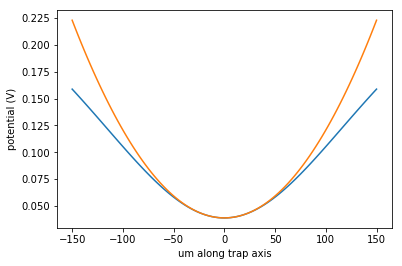

In [8]:
n_points = 101

y_points = np.linspace(-150, 150, n_points)
R = np.array([0, 0, 50])

zeros = np.zeros(n_points)
test_points = np.array([zeros, y_points, zeros]).T + R

exact_potential = vg.compute_potential(test_points, ungrouped_voltages)
ideal_potential = center_potential + yycons * y_points**2

fig, ax = plt.subplots()
ax.set_xlabel("um along trap axis")
ax.set_ylabel("potential (V)")
ax.plot(y_points, exact_potential)
ax.plot(y_points, ideal_potential)

plt.show()

So we see that our fits agree with an ideal harmonic well within $\approx\pm 40 \mu\mathrm{m}$

## Tilting the potential

### Theory (optional-ish)

For better Doppler cooling, we want to tilt the principal axes of the potential
(more accurately, the pseudopotential) so that the Doppler beam $\mathbf k$-vector has a projection
on each axis. Without tilt, we don't get efficient cooling along the $z$-mode,
as our Doppler beam is parallel to the trap.

The idea is to create constraints with the standard trap axes as principal axes,
then rotate coordinate systems to get constraints describing a rotated dc potential.
Note that the tilt angle we would specify in doing so
will give the tilt in the _dc potential only_, **excluding the rf pseudopotential**.
(For that, see below!)

In particular, say our original potential is given by

$$
  \mathbf{s}^T A \mathbf{s}
  =
  [\begin{array}{ccc} x & y & z \end{array}]
  \left[
    \begin{array}{ccc}
      A_{xx} & A_{xy} & A_{xz} \\
      A_{xy} & A_{yy} & A_{yz} \\
      A_{xz} & A_{yz} & A_{zz} \\
    \end{array}
  \right]
  \left[\begin{array}{c} x \\ y \\ z\end{array}\right]
$$

where $\mathbf s$ is the displacement from trap center.
Note that these are different from the coefficients `xx, xy, ...`
described in the code by some factors of 2.
In particular, the diagonal terms are the same (e.g. $A_{xx} = C_{xx}$)
while the off-diagonal terms aren't:

$$
  A_{xy} = \frac 12 C_{xy}.
$$

Introduce rotation matrix

$$
  R = \left[
    \begin{array}{ccc}
      \cos\theta & 0 & -\sin\theta \\
      0 & 1 & 0 \\
      \sin\theta & 0 & \cos\theta \\
    \end{array}
  \right]
$$

which rotates unit vector $\hat x$ by $\theta$ toward $\hat z$.
(Alternatively, this rotates $\hat z$ by $-\theta$ toward $\hat x$.)
Then the potential

$$
  \mathbf{s}^T R^T A R \mathbf{s}
$$

is the potential given by $A$,
except rotated in the $zx$-plane,
with the $z$ principal axis rotated by $+\theta$ toward $x$.

Bashing shows that

$$
  \left[
    \begin{array}{ccc}
      A'_{xx} & A'_{xy} & A'_{xz} \\
      A'_{xy} & A'_{yy} & A'_{yz} \\
      A'_{xz} & A'_{yz} & A'_{zz} \\
    \end{array}
  \right]
  \equiv
  R^T A R = \left[
    \begin{array}{ccc}
      A_{xx}\cos^2\theta + A_{zz}\sin^2\theta + A_{xz} \sin 2\theta & 0 & A_{xz} \cos 2\theta + (A_{zz} - A_{xx})\sin\theta\cos\theta \\
      0 & A_{yy} & 0 \\
      A_{xz} \cos 2\theta + (A_{zz} - A_{xx})\sin\theta\cos\theta & 0 & A_{zz}\cos^2\theta + A_{xx}\sin^2\theta - A_{xz} \sin 2\theta \\
    \end{array}
  \right]
$$

In particular, in terms of the $C_{ij}$ coefficients in the code,

$$
\begin{align*}
  C'_{xx} &= C_{xx} \cos^2\theta + C_{zz} \sin^2\theta + \frac 12 C_{xz} \sin 2\theta \\
  C'_{zz} &= C_{zz} \cos^2\theta + C_{xx} \sin^2\theta - \frac 12 C_{xz} \sin 2\theta \\
  C'_{xz} &= C_{xz} \cos 2\theta + (C_{zz} - C_{xx}) \sin2\theta
\end{align*}
$$

Interestingly, denoting the components of this matrix with a prime as $A'_{xx}$,
we have

$$
  A'_{zz} - A'_{xx} = (A_{zz} - A_{xx}) \cos 2\theta - 2 A_{xz} \sin 2\theta
$$

If we suppose that the unprimed $A$ is diagonal (i.e. principal axes along the coordinate axes),
$A_{xz} = 0$,

$$
  A'_{xz} = \frac 12 (A_{zz} - A_{xx}) \sin2\theta,
$$

and

$$
  \frac{A'_{xz}}{A'_{zz} - A'_{xx}} = \frac12 \tan 2\theta
$$

or in terms of the coefficients used in the code:

$$
  \tan 2\theta = \frac{C'_{xz}}{C'_{zz} - C'_{xx}}
$$

This becomes relevant when we try to account for the pseudopotential.

### Implementation

The function `VoltageGeneration.rotate_coeffs` transforms $C \mapsto C'$.

For example, consider an untilted potential with `xx = 3` and `zz = -4`. If we take this potential and rotate the $z$ principal axis toward $x$ by $15^\circ$, we would get the following `xx, xz, zz` values

In [10]:
print(VoltageGeneration.rotate_coeffs(np.radians(15), 3, 0, -4))

[2.531088913245535, -3.4999999999999996, -3.5310889132455356]


In general, to rotate a potential, we come up with the constraints for the untilted potential, then use `rotate_coeffs` to find constraints that produce the rotated potential. To rotate our previous potential by $15^\circ$, for example:

In [11]:
xxt, xzt, zzt = VoltageGeneration.rotate_coeffs(np.radians(15), xxcons, 0, zzcons)

constraints = [('yy', yycons), ('xx', xxt), ('zz', zzt), ('xz', xzt), ('xy', 0), ('yz', 0)]

R = [0, 0, 50]

t = time.time()
tilted_voltages = vg.findControlVoltages([R], cons=[constraints])
print(tilted_voltages)
print("Time taken: {:.3f} s".format(time.time()-t))

[ 1.66780363  0.98912776  2.02749943  1.35042534 -5.55900854  1.36181095
  2.02975713  0.98514685  1.52826971 -0.2122872   0.41170436  1.59279274
  0.91726611  1.84915759  0.81318221 -6.51356143  0.82480683  1.84948327
  0.91647954  1.45923152]
Time taken: 0.123 s


Of course, the actual tilt of the combined rf + dc pseudopotential is not necessarily what we program here, since it only includes the dc potential.

To look at the tilt, we can use `VoltageGeneration.compute_total_potential_axes`. On the untilted voltages:

In [12]:
_ = vg.compute_total_potential_axes(R, app_voltages)

Hessian:
[[3.13926918e-04 4.92628160e-09 4.75214085e-09]
 [4.92628160e-09 8.19433803e-06 3.33623908e-08]
 [4.75214085e-09 3.33623908e-08 3.42206620e-04]]
Frequencies in Hz: [1000781.32570986 6194362.58581068 6467352.78552115]
Corresponding axes (as row vectors):
 [[ 1.61114882e-05 -9.99999995e-01  9.98834939e-05]
 [ 9.99999986e-01  1.60947017e-05 -1.68059675e-04]
 [-1.68058067e-04 -9.98862002e-05 -9.99999981e-01]]


The axes are pretty axis-parallel.

In [13]:
hessian, sec_freqs, axes = vg.compute_total_potential_axes(R, tilted_voltages)

Hessian:
[[3.17765033e-04 4.93770312e-09 1.43271226e-05]
 [4.93770312e-09 8.19468419e-06 3.17486785e-08]
 [1.43271226e-05 3.17486785e-08 3.38369274e-04]]
Frequencies in Hz: [1000802.48307017 6159672.57614391 6500408.26957173]
Corresponding axes (as row vectors):
 [[ 1.15231006e-05 -9.99999995e-01  9.56572255e-05]
 [ 8.89888832e-01 -3.33823908e-05 -4.56177450e-01]
 [-4.56177451e-01 -9.03808753e-05 -8.89888827e-01]]


The tilt is then the angle of the $z$ principal axis (the last vector here) off from $z$; in this case we can compute it as
$$
  \tan \theta = \frac{v_x}{v_z}
$$

In [14]:
actual_tilt_angle = np.arctan(axes[2,0]/axes[2,2])
print("Tilt angle: {:.2f} deg".format(np.degrees(actual_tilt_angle)))

Tilt angle: 27.14 deg


Note that this is very much _not_ 15 degrees.

### Including the rf pseudopotential

As of now, our code does not account for the rf pseudopotential when it does fitting (though this is a possibility for the future). We can work around this by varying the tilt angle of the dc potential until the full rf+dc pseudopotential has the desired tilt. This is what we do in `VoltageGeneration.tilt_with_pseudo` (side note: this is where we use the neat formula for $\tan 2\theta$ from above).

In [15]:
xxt, xzt, zzt = vg.tilt_with_pseudo(R, np.radians(15), yycons)

constraints = [('yy', yycons), ('xx', xxt), ('zz', zzt), ('xz', xzt), ('xy', 0), ('yz', 0)]

t = time.time()
tilted_with_pseudo_voltages = vg.findControlVoltages([R], cons=[constraints])
print(tilted_with_pseudo_voltages)
print("Time taken: {:.3f} s".format(time.time()-t))

[ 5.37517391  2.740054    1.76146546 -2.73651641 -5.70720917 -2.60726077
  1.61109161  2.07961723  5.12934373 -0.19308793  0.12705288  3.51490764
  2.03563965  1.73353257 -2.88710945 -5.95348081 -2.91492909  1.95672238
  2.59422649  2.31247455]
Time taken: 0.114 s


Again we can find the principal axes:

In [16]:
hessian, sec_freqs, axes = vg.compute_total_potential_axes(R, tilted_with_pseudo_voltages)

Hessian:
[[3.14935586e-04 4.92814800e-09 7.57554498e-06]
 [4.92814800e-09 8.18438135e-06 3.35324447e-08]
 [7.57554498e-06 3.35324447e-08 3.41177996e-04]]
Frequencies in Hz: [1000173.13055049 6184279.34056118 6476807.07030185]
Corresponding axes (as row vectors):
 [[ 1.35863601e-05 -9.99999995e-01  1.00390874e-04]
 [ 9.65925727e-01 -1.28596927e-05 -2.58819415e-01]
 [-2.58819415e-01 -1.00486542e-04 -9.65925722e-01]]


This time, the tilt angle is exactly what we wanted:

In [17]:
actual_tilt_angle = np.arctan(axes[2,0]/axes[2,2])
print("Tilt angle: {:.2f} deg".format(np.degrees(actual_tilt_angle)))

Tilt angle: 15.00 deg
